In [1]:
import sys
sys.path.append('/Users/owenwei/opt/anaconda3/lib/python3.9/site-packages')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.sparse import csr_matrix

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from kerastuner.tuners import RandomSearch

2023-03-19 16:53:13.082283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/mn/g_27w4214xqgf96fjfd220hr0000gn/T/ipykernel_97958/1279640156.py:38: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Preprocessing
##### Determining Missing Values

In [2]:
data = pd.read_csv('train.csv')

In [3]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[(df_NA.T != 0).any()]
    
    return df_NA

In [4]:
assess_NA(data)

,Number of NA,Percent NA
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


In [5]:
def remove_NA_col_row(df):
    """
    Returns a pandas dataframe without NA rows and some columns with many NA values
    
    Parameters
    ----------
    df: dataframe
    """
    # For example, PoolQC：Pool quality. NA = No Pool, so 99.52% data without pool
    # Drop the column with many NA
    df = df.drop(columns=['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'])

    # Drop rows with null values
    df = df.dropna(axis=0)

    # Drop rows with null values
    df = df.reset_index()
    df = df.drop(columns=['index'])
    
    return df

In [6]:
# dataframe without NA
data_clean = remove_NA_col_row(data)
#data_clean

In [7]:
def oneHotEncode(df,colNames):
    """
    Returns a pandas dataframe after only transfering categorical feature to oneHotEncode
    
    Parameters
    ----------
    df: dataframe
    colNames: the column names of dataframe
    """
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            #get_dummies to apply One-Hot Encode
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)
            
            # drop the encoded column
            df.drop([col],axis = 1,inplace=True)
    return df

In [8]:
def boxplots(x,lim):
    """
    Side by side boxplots for numerical features
    
    Parameters
    ----------
    df: dataframe for numerical data
    lim: zoom in or not
    """
    # EDA for numerical feature
    fig, ax = plt.subplots()

    # build a box plot
    ax.boxplot(x)

    # title and axis labels
    ax.set_title('box plot')
    ax.set_xlabel('features')
    ax.set_ylabel('value')
    xticklabels=x_num.columns
    ax.set_xticklabels(xticklabels, rotation=45, rotation_mode="anchor")

    # Set the figure size
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.rcParams["figure.autolayout"] = True
    
    if lim == 1:
        plt.ylim(-500,10000)

    # show the plot
    plt.show()
    

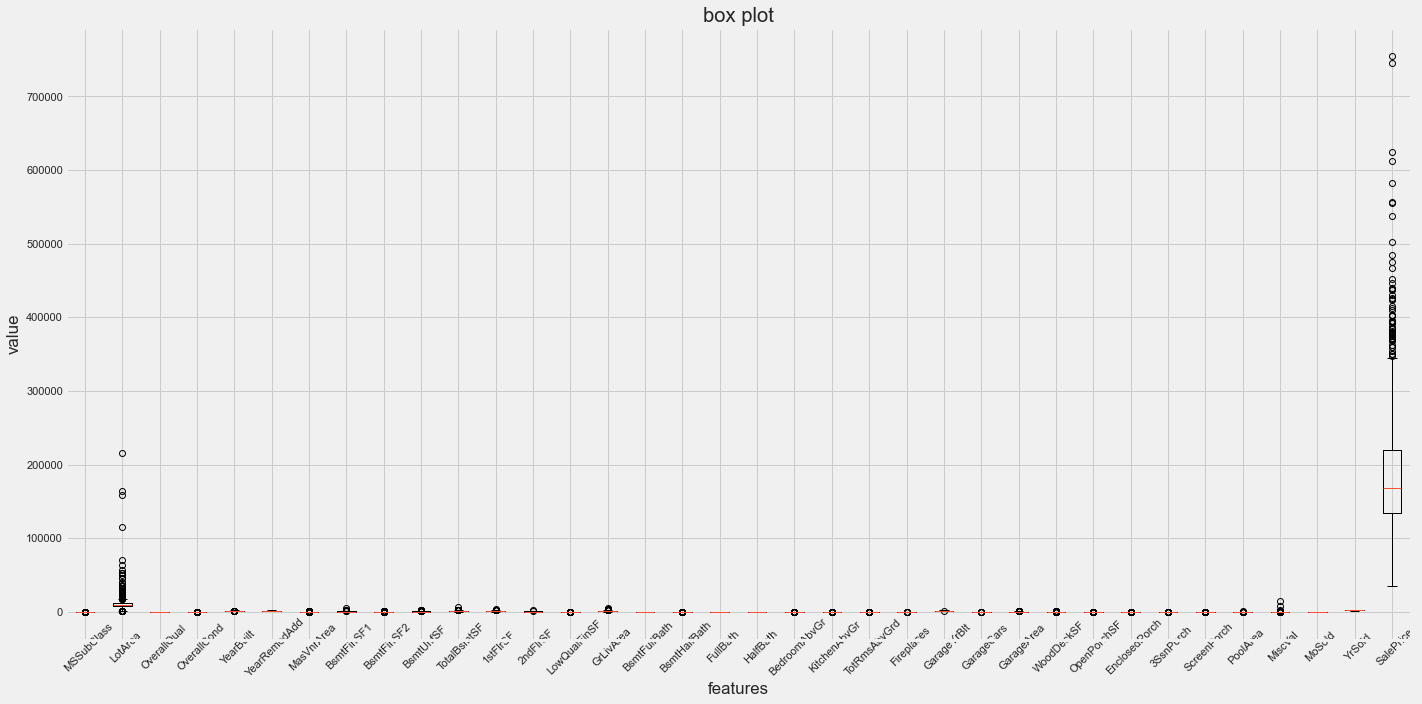

In [44]:
x_num = data_clean.select_dtypes(exclude = ['object'])
boxplots(x_num,0)

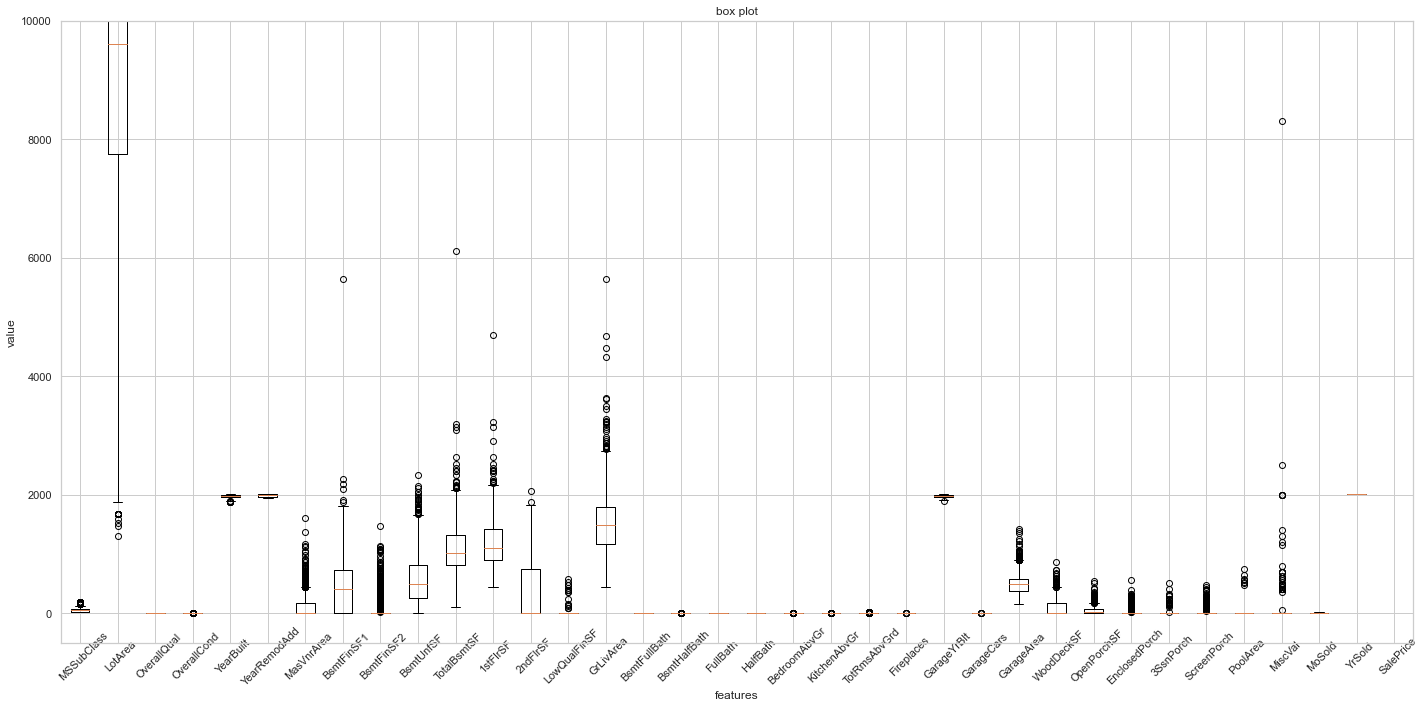

In [10]:
boxplots(x_num,1)

lots of outliers in LotArea, there is some outliers in other features after zooming in.

### Standardization for numerical data and oneHotEncode for categorical data

In [11]:
def standardizationAndOneHotEncode(data):
    """
    Returns a pandas dataframe with standardization for numerical data and oneHotEncode for categorical data
    
    Parameters
    ----------
    df: dataframe without NA
    """
    # get the numerical data
    data_num = data.select_dtypes(exclude = ['object'])
    x_num = data_num.iloc[:,0:data_num.shape[1]-1]
    #y = data_num.iloc[:,-1]

    std = StandardScaler()
    # standardization 
    x_scale = std.fit_transform(x_num) 
    # Convert standardized numerical data to a DataFrame
    x_scale = pd.DataFrame(x_scale,columns=x_num.columns)
    
    # get the categorical data and apply oneHotEncode
    data_cal = data.select_dtypes(include = ['object'])
    data_oneHot_dummy = oneHotEncode(data_cal,data_cal.columns)

    # conbine dummies and standardized x
    df_x = pd.concat([x_scale,data_oneHot_dummy],axis=1)
    return df_x

In [12]:
# Standardization for numerical data and oneHotEncode for categorical data
df_x = standardizationAndOneHotEncode(data_clean)

In [45]:
df_x

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.093701,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,...,0,0,0,1,0,0,0,0,1,0
1,-0.876298,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,...,0,0,0,1,0,0,0,0,1,0
2,0.093701,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,...,0,0,0,1,0,0,0,0,1,0
3,0.336201,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,...,0,0,0,1,1,0,0,0,0,0
4,0.093701,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.093701,-0.269947,-0.165963,-0.553402,0.878804,0.706352,-0.594820,-1.012240,-0.296255,0.842467,...,0,0,0,1,0,0,0,0,1,0
1334,-0.876298,0.238920,-0.165963,0.374482,0.168204,0.114895,0.046567,0.710315,0.684878,0.014792,...,0,0,0,1,0,0,0,0,1,0
1335,0.336201,-0.161070,0.589337,3.158135,-1.083805,1.002081,-0.594820,-0.412617,-0.296255,0.669656,...,0,0,0,1,0,0,0,0,1,0
1336,-0.876298,-0.095744,-0.921263,0.374482,-0.779263,0.509200,-0.594820,-0.905398,5.897523,-1.324496,...,0,0,0,1,0,0,0,0,1,0


### Split the Training and Testing Dataset for Random Forest

In [13]:
xy = oneHotEncode(data_clean,data_clean.columns)
y = xy.pop('SalePrice')
x = xy

In [14]:
#splite the test and train dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

### Null Model and model performance function

In [15]:
# The baseline predictions are the historical averages
baseline_preds = np.mean(y_train)
# define the null model
null_model_predictions = np.ones(len(y_test))*baseline_preds

In [16]:
def modelPerformance(y_test, predictions):
    """
    Returns a list of measures of prediction accuracy: mae, mse, rmse, accuracy, r2_score
    
    Parameters
    ----------
    predictions: the list of predicted value by model
    y_test: the ture test value
    """
    result = []
    # Calculate the absolute errors
    errors = abs(predictions - y_test)
    # mean absolute error (mae)
    mae = np.mean(errors)
    # print('Mean Absolute Error:', round(mae, 2), 'degrees.')
    result.append(mae)
    
    mse = mean_squared_error(y_test, predictions)
    result.append(mse)
    rmse = mse**0.5
    result.append(rmse)
    
    # Calculate mean absolute percentage error (MAPE)
    mape = 1 * (errors / y_test)
    # Calculate accuracy
    accuracy = 1 - np.mean(mape)
    result.append(accuracy)
    
    r2 = r2_score(y_test, predictions)
    result.append(r2)
    
    return result


In [17]:
null_model_performance = modelPerformance(y_test, null_model_predictions)

### Random Forest Regression

In [18]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 666)

# Train the model on training data
rf.fit(x_train, y_train)

# Use the forest's predict method on the test data
rf_predictions = rf.predict(x_test)

In [19]:
# get the performance of the model
rf_performance = modelPerformance(y_test, rf_predictions)

In [20]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = x.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [21]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
# print(feature_importances)

In [51]:
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: OverallQual          Importance: 0.58
Variable: GrLivArea            Importance: 0.12
Variable: BsmtFinSF1           Importance: 0.04
Variable: TotalBsmtSF          Importance: 0.03
Variable: 1stFlrSF             Importance: 0.03
Variable: LotArea              Importance: 0.02
Variable: TotRmsAbvGrd         Importance: 0.02
Variable: YearBuilt            Importance: 0.01
Variable: YearRemodAdd         Importance: 0.01
Variable: BsmtUnfSF            Importance: 0.01
Variable: 2ndFlrSF             Importance: 0.01
Variable: FullBath             Importance: 0.01
Variable: GarageCars           Importance: 0.01
Variable: GarageArea           Importance: 0.01
Variable: MSSubClass           Importance: 0.0
Variable: OverallCond          Importance: 0.0
Variable: MasVnrArea           Importance: 0.0
Variable: BsmtFinSF2           Importance: 0.0
Variable: LowQualFinSF         Importance: 0.0
Variable: BsmtFullBath         Importance: 0.0
Variable: BsmtHalfBath         Importance: 0.0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

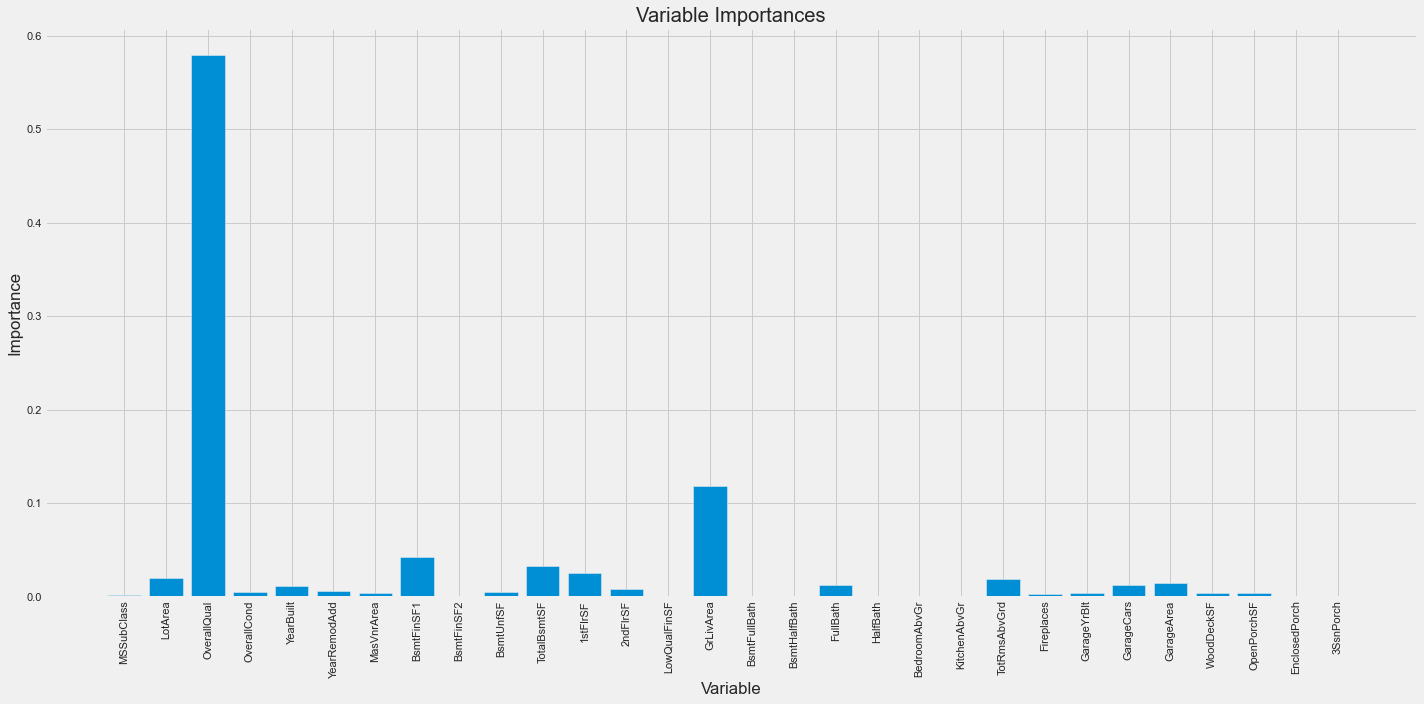

In [22]:
feature_list = list(x.columns)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances[0:30])))
# Make a bar chart
plt.bar(x_values, importances[0:30], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list[0:30], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [23]:
# New random forest with the 3 most important variables
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state=888, max_depth = 3)
# Extract the 3 most important features
important_indices = [feature_list.index('OverallQual'), feature_list.index('GrLivArea'), feature_list.index('BsmtFinSF1')]
x_train_important = x_train.iloc[:, important_indices]
x_test_important = x_test.iloc[:, important_indices]
# Train the random forest
rf_most_important.fit(x_train_important, y_train)
# Make predictions and determine the error
rf_most_important_predictions = rf_most_important.predict(x_test_important)
# get the performance of the model
rf_most_important_performance = modelPerformance(y_test, rf_most_important_predictions)

In [24]:
# Pull out one tree from the forest
tree = rf_most_important.estimators_[6]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree_most_important.dot', feature_names = x_train_important.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree_most_important.dot')
# Write graph to a png file
graph.write_png('tree_most_important.png')

In [25]:
# def plotGraph(y_test,y_pred,regressorName):
#     if max(y_test) >= max(y_pred):
#         my_range = int(max(y_test))
#     else:
#         my_range = int(max(y_pred))
#     plt.scatter(range(len(y_test)), y_test, color='blue')
#     plt.scatter(range(len(y_pred)), y_pred, color='red')
#     plt.title(regressorName)
#     plt.show()
#     return

# y_pred = rf_most_important.predict(x_test_important)

# plotGraph(y_test, y_pred, "test")

### PCA 

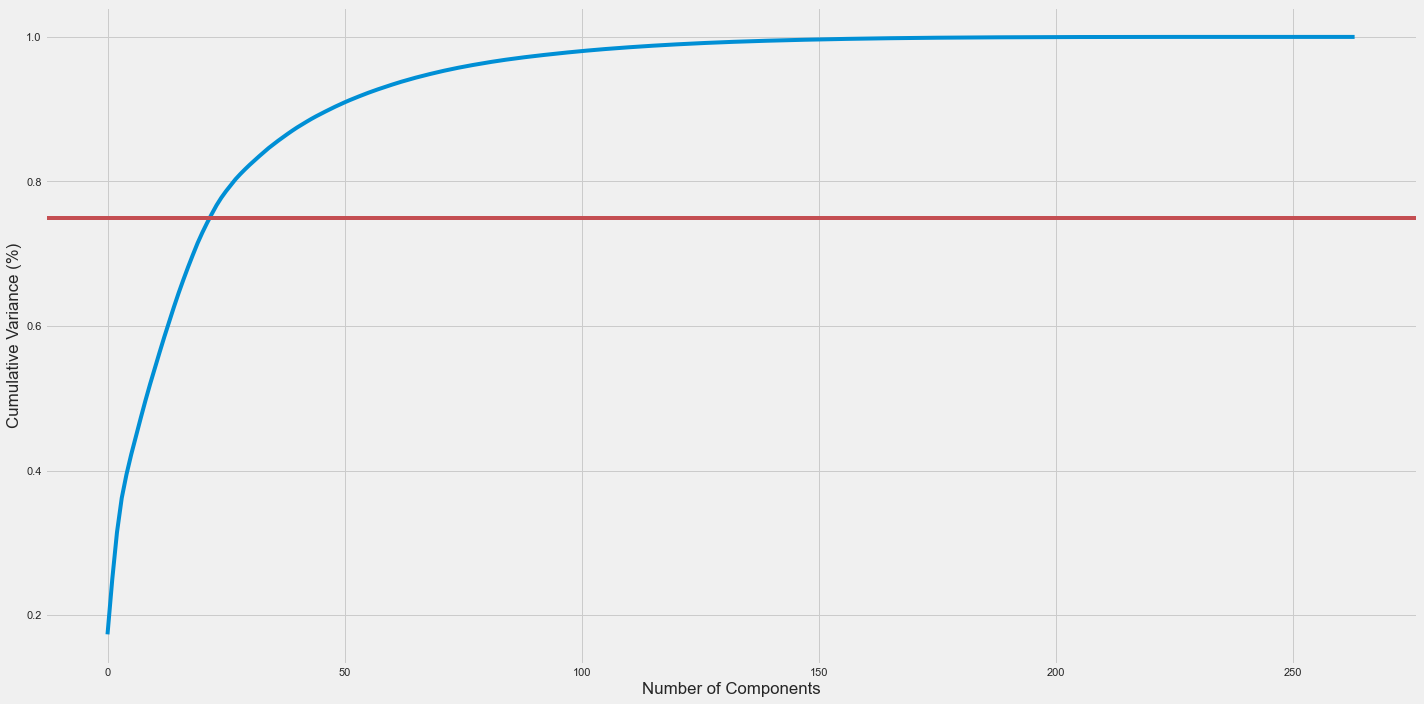

23 components have at least 75% of the variance.


In [26]:
# Fit the standardized data with PCA
pca = PCA().fit(df_x)

# Create the cumulative variance plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.axhline(y=0.75, color='r', linestyle='-') 
plt.show()

# add 1 to the index of the first principal component that contributes to at least 75% of the variance, because the array indices are zero-based in Python.
n = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.75)[0][0]+1
print(str(n) + " components have at least 75% of the variance.")

### PCA transformation

In [27]:
# n components have at least 75% of variance
pca = PCA(n_components=n)
# transform x
x_pca = pca.fit_transform(df_x)

### Linear Regression with PCA variables

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state = 0)

In [29]:
# Train a regression model on the transformed data
reg = LinearRegression()
reg.fit(x_train, y_train)
LR_PCA_predictions = reg.predict(x_test)

# Evaluate the model on the test set
LR_PCA_Performance = modelPerformance(y_test, LR_PCA_predictions)

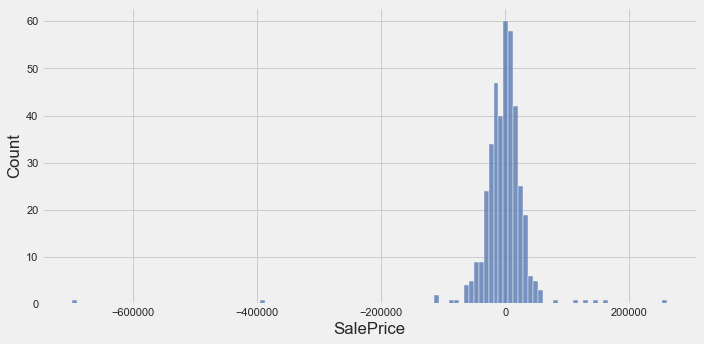

In [30]:
# visualizing residuals
x = list(range(len(y_test)))
fig = plt.figure(figsize=(10,5))
residuals = (y_test - LR_PCA_predictions)
#sns.scatterplot(x, residuals)
sns.histplot(residuals)
# show the plot
plt.show()

### CV Lasso

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.3, random_state = 0)

In [32]:
# Run 8-fold cross-validation to estimate the R^2 of the full model
cv_reg = LassoCV(cv=5, random_state=0, normalize=False)
cv_reg.fit(x_train, y_train)

# Use cross-validation to obtain lambda_min
lambda_min = cv_reg.alpha_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [61]:
lambda_min

count = 0
for i in range(len(lasso_best_coef)):
    if lasso_best_coef[i][0] > 0:
        count = count + 1
        
print(count)

60


In [33]:
# Set best alpha in lasso regression
lasso_best = Lasso(alpha=cv_reg.alpha_)
lasso_best.fit(x_train, y_train)

#Store model coefficients and names
lasso_best_coef = list(zip(lasso_best.coef_, df_x))

# predict the prices by best alpha in lasso regression
Lasso_Best_predictions = lasso_best.predict(x_test)
# Evaluate the model on the test set
Lasso_Best_Performance = modelPerformance(y_test, Lasso_Best_predictions)

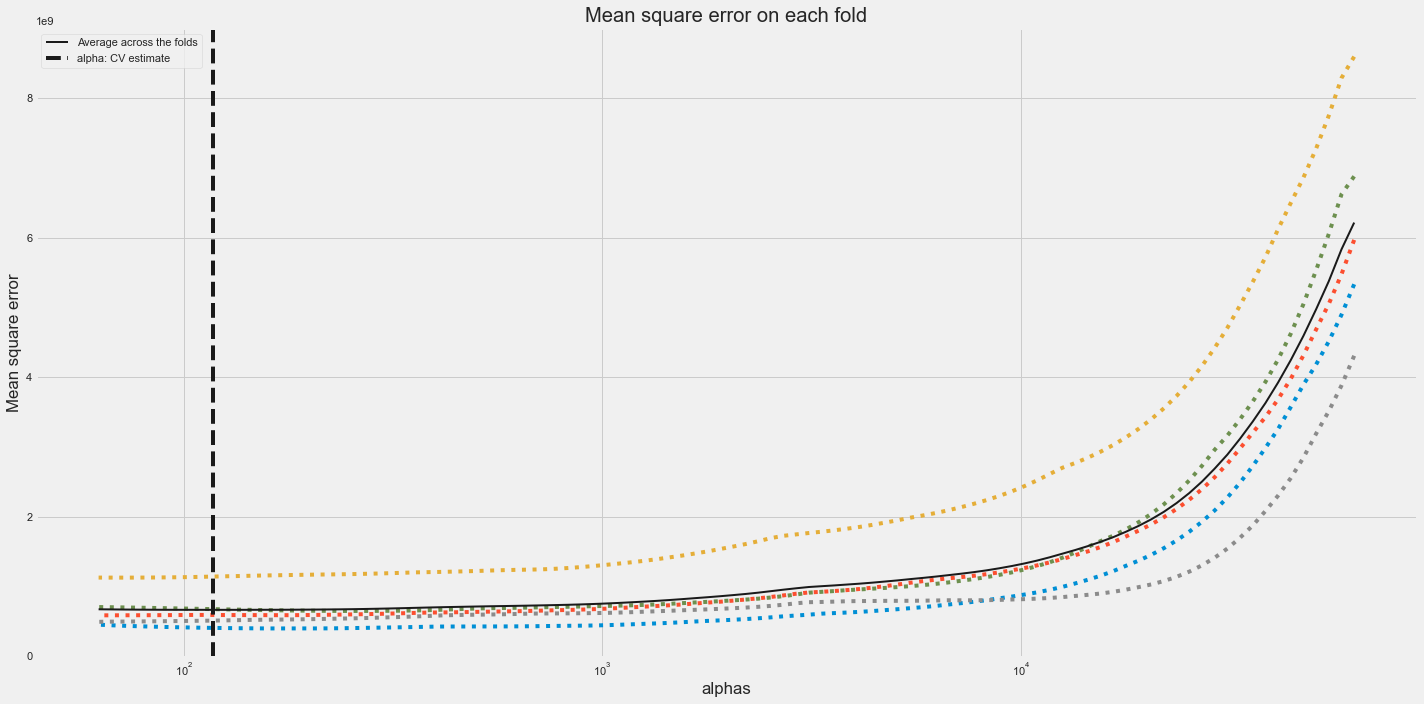

In [34]:
plt.semilogx(cv_reg.alphas_, cv_reg.mse_path_, ":")
plt.plot(
    cv_reg.alphas_ ,
    cv_reg.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(cv_reg.alpha_, linestyle="--", color="k", label="alpha: CV estimate")

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
# Set the figure size
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

### Neural Network: Fully Connected Neural Network (MLP)

In [35]:
# get the numerical data
data_num = data_clean.select_dtypes(exclude = ['object'])
x_train, x_test, y_train, y_test = train_test_split(data_num, y, test_size=0.3, random_state = 0)

In [36]:
def build_model(hp):
    """
    Returns a MLP model with the best model
    
    Parameters
    ----------
    hp: hyperparameters
    """
    
    model = Sequential()
    for i in range(hp.Int('layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                                            #kernel_initializer='random_normal',
                                            #kernel_regularizer= tf.keras.regularizers.l2(0.03),
                                            activation='relu'))
    model.add(Dense(1)) # one single output
    
    model.compile(optimizer = 
                  Adam(hp.Choice('learning_rate', [0.001, 0.002, 0.003])), # optimizer: adam
                  loss='mse', # loss mse
                  #loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM),
                  metrics=['mse'])
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30, # the maximum number of hyperparameter combinations to try during the search
    executions_per_trial=3, # how many times to train and evaluate each model with different random initializations
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(x_train, y_train, batch_size = 128, epochs = 30, validation_data=(x_test, y_test))

Trial 30 Complete [00h 00m 06s]
val_mse: 66997.97265625

Best val_mse So Far: 31693.055338541668
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


In [38]:
model = tuner.get_best_models(1)[0]

In [39]:
epochs = 30
def hist(model):
    history = model.fit(
      x=x_train,y=y_train,
        validation_data=(x_test,y_test),
        batch_size=128,epochs=epochs
        )

    return history

## Visualization
def Vis(history):
    ## Visualize the output
    acc = model.history.history['mse']
    val_acc = model.history.history['val_mse']

    loss=model.history.history['loss']
    val_loss=model.history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training mse')
    plt.plot(epochs_range, val_acc, label='Validation mse')
    plt.legend(loc='lower right')
    plt.title('Training and Validation mse')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


Epoch 1/30
8/8 [==============================] - 1s 24ms/step - loss: 10738.0879 - mse: 10738.0879 - val_loss: 13033.0176 - val_mse: 13033.0176
Epoch 2/30
8/8 [==============================] - 0s 6ms/step - loss: 10704.7646 - mse: 10704.7646 - val_loss: 9903.4287 - val_mse: 9903.4287
Epoch 3/30
8/8 [==============================] - 0s 6ms/step - loss: 9357.7393 - mse: 9357.7393 - val_loss: 9474.5215 - val_mse: 9474.5215
Epoch 4/30
8/8 [==============================] - 0s 7ms/step - loss: 8318.9707 - mse: 8318.9707 - val_loss: 9016.3008 - val_mse: 9016.3008
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 7777.3340 - mse: 7777.3340 - val_loss: 8691.0586 - val_mse: 8691.0586
Epoch 6/30
8/8 [==============================] - 0s 7ms/step - loss: 7466.5229 - mse: 7466.5229 - val_loss: 8410.1875 - val_mse: 8410.1875
Epoch 7/30
8/8 [==============================] - 0s 5ms/step - loss: 7022.4023 - mse: 7022.4023 - val_loss: 8008.3301 - val_mse: 8008.3301
Epoch 8/30
8/

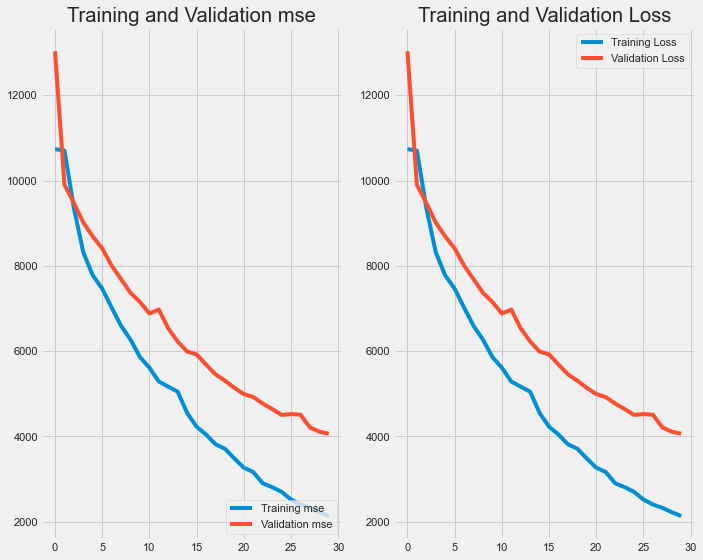

In [40]:
history = hist(model)
Vis(history)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               8288      
                                                                 
 dense_1 (Dense)             (None, 160)               36000     
                                                                 
 dense_2 (Dense)             (None, 192)               30912     
                                                                 
 dense_3 (Dense)             (None, 64)                12352     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 89,665
Trainable params: 89,665
Non-traina

In [42]:
y_pred = model.predict(x_test)
MLP_predictions = np.ravel(y_pred) # transform the array as one dimensional

# Evaluate the model on the test set
MLP_Performance = modelPerformance(y_test, MLP_predictions)

13/13 [==============================] - 0s 1ms/step


### Summary

In [43]:
method=['Null Model','Random Forest','Random Forest with 3 most important features',
       'Linear Regression and PCA with 75% variance','Linear Regression with CV Lasso',
       'Fully Connected Neural Network']

cols=['MAE', 'MSE', 'RMSE', 'Accuracy', 'R2_Score']

Summary = pd.DataFrame(columns=cols)

Summary.loc[0] = null_model_performance
Summary.loc[1] = rf_performance
Summary.loc[2] = rf_most_important_performance
Summary.loc[3] = LR_PCA_Performance
Summary.loc[4] = Lasso_Best_Performance
Summary.loc[5] = MLP_Performance
Summary.insert(0, 'Model', method)

print(Summary)
Summary

                                          Model           MAE           MSE  \
0                                    Null Model  55630.319620  6.030020e+09   
1                                 Random Forest  18093.889211  1.559135e+09   
2  Random Forest with 3 most important features  28783.767199  2.252446e+09   
3   Linear Regression and PCA with 75% variance  23098.317133  2.550220e+09   
4               Linear Regression with CV Lasso  18657.301478  2.331727e+09   
5                Fully Connected Neural Network     36.461239  4.064577e+03   

           RMSE  Accuracy  R2_Score  
0  77653.204395  0.670760 -0.002141  
1  39485.880973  0.901061  0.740884  
2  47459.944047  0.831166  0.625661  
3  50499.699146  0.867282  0.576174  
4  48287.960806  0.892723  0.612485  
5     63.754032  0.999782  0.999999  


,Model,MAE,MSE,RMSE,Accuracy,R2_Score
0,Null Model,55630.319620,6.030020e+09,77653.204395,0.670760,-0.002141
1,Random Forest,18093.889211,1.559135e+09,39485.880973,0.901061,0.740884
2,Random Forest with 3 most important features,28783.767199,2.252446e+09,47459.944047,0.831166,0.625661
3,Linear Regression and PCA with 75% variance,23098.317133,2.550220e+09,50499.699146,0.867282,0.576174
4,Linear Regression with CV Lasso,18657.301478,2.331727e+09,48287.960806,0.892723,0.612485
5,Fully Connected Neural Network,36.461239,4.064577e+03,63.754032,0.999782,0.999999


In [48]:
Summary.to_csv('Model_Summary.csv', index=False)